In [4]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score

In [6]:
data_polling = pd.read_stata("Data/cumulative_2006_2018.dta")

In [7]:
inputs = ['year','st','gender', 'age', 'race', 'hispanic', 'educ', 'faminc', 'marstat', 'economy_retro', 'newsint','approval_pres']
targets = ['pid3']

keep = inputs + targets

data_polling = data_polling[(data_polling.year == 2018) & (data_polling.pid3.isin(['Democrat','Republican']) )]

polling = data_polling[keep]

In [8]:
polling.dropna(axis=0, how='any',inplace=True)

/Users/amandahutter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
pd.options.mode.chained_assignment = None  # default='warn'

polling['age_band'] = np.NaN
polling.loc[ (polling['age'] >= 18) & (polling['age'] <= 29), 'age_band'] = 'Young'
polling.loc[ (polling['age'] >= 30) & (polling['age'] <= 49), 'age_band'] = 'Lower-Middle'
polling.loc[ (polling['age'] >= 50) & (polling['age'] <= 69), 'age_band'] = 'Upper-Middle'
polling.loc[ (polling['age'] >= 70) , 'age_band'] = 'Old'

polling.loc[ polling['pid3'] == "Democrat", "Dem_Ind"] = 1
polling.loc[ polling['pid3'] == 'Republican', "Dem_Ind"] = 0
polling['Dem_Ind'] = polling['Dem_Ind'].astype(int)

categorical_polling = ['st','gender', 'age_band', 'race', 'hispanic', 'educ', 'faminc', 'marstat', 'economy_retro', 'newsint','approval_pres']

In [10]:
polling.head()

,year,st,gender,age,race,hispanic,educ,faminc,marstat,economy_retro,newsint,approval_pres,pid3,age_band,Dem_Ind
392756,2018,OH,Female,58,White,No,Post-Grad,150k+,Married,Stayed About The Same,Only Now And Then,Approve / Somewhat Approve,Republican,Upper-Middle,0
392757,2018,KY,Female,66,White,No,Post-Grad,10k - 20k,Divorced,Stayed About The Same,Most Of The Time,Strongly Disapprove,Democrat,Upper-Middle,1
392758,2018,AZ,Female,88,White,No,High School Graduate,20k - 30k,Widowed,Gotten Much Better,Some Of The Time,Approve / Somewhat Approve,Republican,Old,0
392760,2018,NC,Male,71,White,No,High School Graduate,50k - 60k,Married,Gotten Much Better,Some Of The Time,Strongly Approve,Republican,Old,0
392761,2018,PA,Male,86,White,No,4-Year,60k - 70k,Widowed,Gotten Better / Somewhat Better,Most Of The Time,Strongly Approve,Republican,Old,0


In [11]:
small_polling = polling.sample(n=10000, random_state = 42)

X_polling = small_polling[categorical_polling]

y_polling = small_polling.loc[:,'Dem_Ind']

General Use Functions

In [12]:
from sklearn.preprocessing import OneHotEncoder

def prep_data(X, y, categoricalVars):

    encoder = OneHotEncoder(sparse=False)
    X_encoded = pd.DataFrame(encoder.fit_transform(X[categoricalVars]))
    X_encoded.columns = encoder.get_feature_names(categoricalVars)
    X.drop(categoricalVars, axis = 1, inplace = True)
    if X.shape[1] > 0:
        OH_X = pd.concat([X, pd.DataFrame(X_encoded, index=X.index)], axis = 1)
    else:
        OH_X = X_encoded 
        
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(OH_X, y, test_size = .30, train_size = .70, random_state = 42)
    return(X_Train, X_Test, Y_Train, Y_Test)

In [13]:
X_Train_Polling, X_Test_Polling, Y_Train_Polling, Y_Test_Polling = prep_data(X_polling, y_polling, categorical_polling)

### Tutorial for K-Means

Selecting the Number of clusters with silhouette analysis on KMeans Clustering

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

- Silhoutte is a metric used to measure the separation distance between clusters 
- Silhoutte measure ranges from -1 to 1. 
- Silhoutte values near +1: good, sample is far from neighboring cluster
- Silhoutte values near 0: Samples is on or near the decision boundary between two clusters 
- Silhoutte values < 0: Bad, Samples may be assigned to wrong cluster 
- Vary the n_clusters and examine silhoutte metric 

In [32]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt 
import matplotlib.cm as cm 
import numpy as np 

X, y = make_blobs(n_samples = 500, n_features = 2, centers = 4, cluster_std = 1, center_box = (-10.0, 10.0), shuffle = True, random_state = 1)

print(X.shape)
print(y.shape)

(500, 2)
(500,)


In [33]:
range_n_clusters = [2, 3, 4, 5, 6]

For N clusters: 2 ,The Average silhouette score is : 0.7049787496083262
For N clusters: 3 ,The Average silhouette score is : 0.5882004012129721
For N clusters: 4 ,The Average silhouette score is : 0.6505186632729437
For N clusters: 5 ,The Average silhouette score is : 0.5745566973301872
For N clusters: 6 ,The Average silhouette score is : 0.4387644975296138


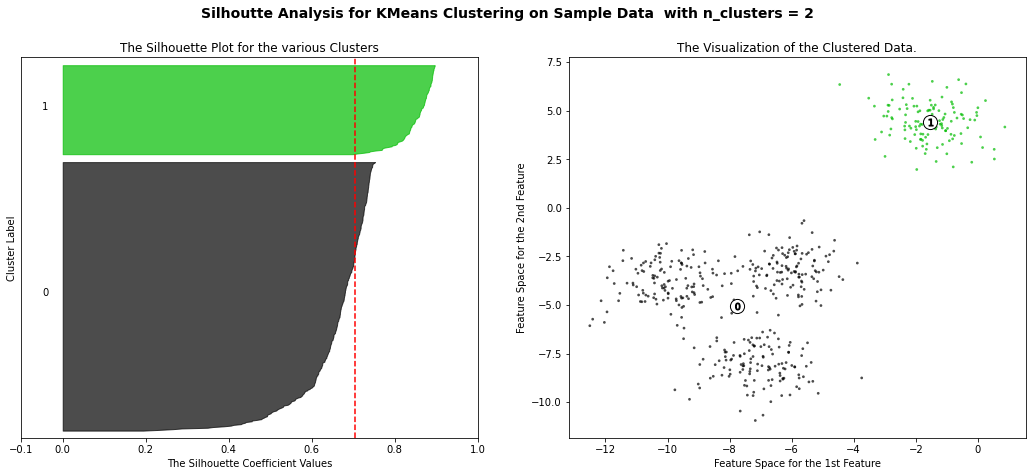

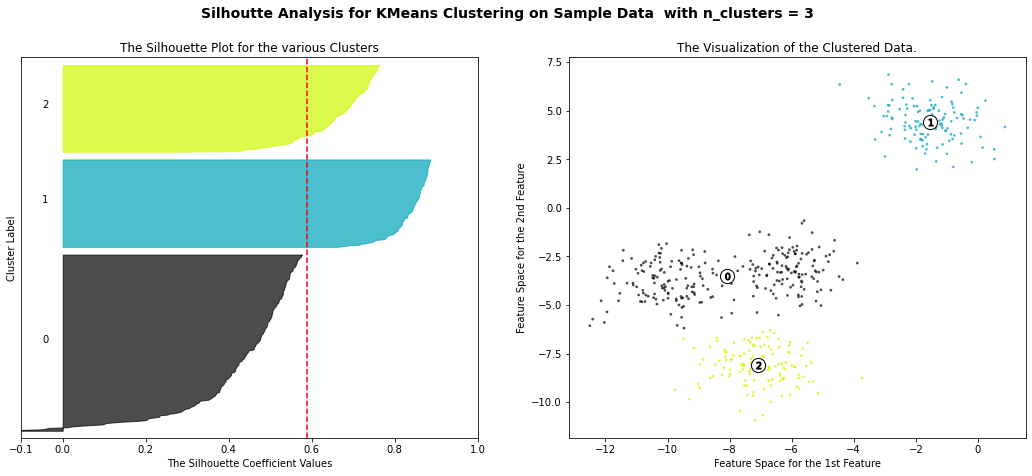

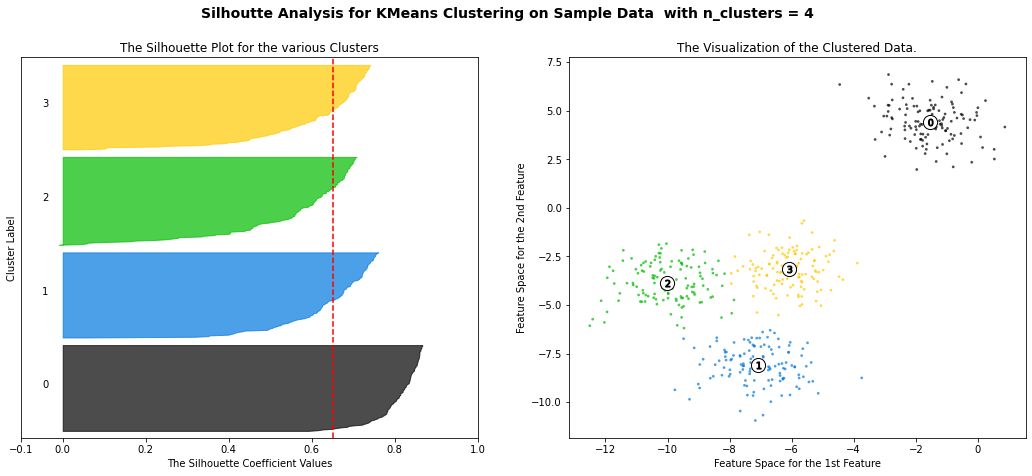

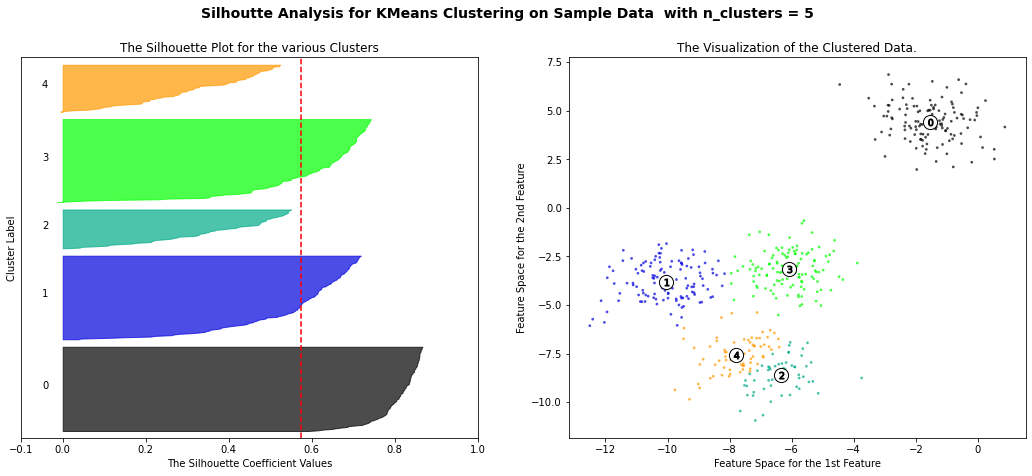

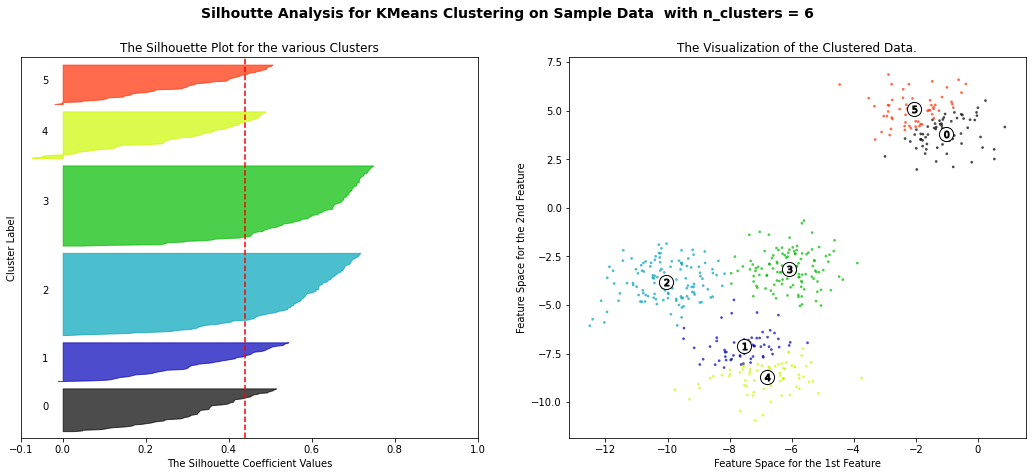

In [34]:
for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Silhouette Plot 
    ax1.set_xlim([-.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1)*10])
    
    # initialize the clusterer with the n_clusters value 
    clusterer = KMeans(n_clusters=n_clusters, random_state = 10)
    cluster_labels = clusterer.fit_predict(X)
    
    # Silhouette_score gives avg value for all samples 
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For N clusters:", n_clusters, ",The Average silhouette score is :", silhouette_avg)
    
    # Get Silhouette Scores for each sample 
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        
        # Aggregate scores for samples in the ith cluster, and sort 
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, 
                         facecolor = color, edgecolor = color, alpha = 0.7)
        
        # Label the silhouette plots with the cluster number in the middle 
        ax1.text(-0.05, y_lower + 0.5*size_cluster_i, str(i))
        
        # Computer the new y_lower for the next plot 
        y_lower = y_upper + 10 # Without this step, plots are all on top of each other 
        
    ax1.set_title("The Silhouette Plot for the various Clusters")
    ax1.set_xlabel("The Silhouette Coefficient Values")
    ax1.set_ylabel("Cluster Label")
    
    # The Vertical Line for avg. Silhouette Score of all the values 
    ax1.axvline(x = silhouette_avg, color = 'red', linestyle = "--")
    
    ax1.set_yticks([]) # Clear the Y Axis 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot shows the actual clusters formed 
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker = ".", s=30, lw=0, alpha=0.7,
               c = colors, edgecolor = 'k')

    # Label the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers 
    ax2.scatter(centers[:, 0], centers[:, 1], marker = 'o', 
               c = 'white', alpha = 1, s = 200, edgecolor = 'k')
    
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker = '$%d$' % i, alpha = 1, 
                   s = 50, edgecolor = 'k')
    
    ax2.set_title("The Visualization of the Clustered Data.")
    ax2.set_xlabel("Feature Space for the 1st Feature")
    ax2.set_ylabel("Feature Space for the 2nd Feature")
    
    plt.suptitle(("Silhoutte Analysis for KMeans Clustering on Sample Data "
                    " with n_clusters = %d" %n_clusters),
                fontsize = 14, fontweight = 'bold')
    
    
plt.show()

In [69]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

X_digits, y_digits = load_digits(return_X_y=True)

data = scale(X_digits)

n_samples, n_features = data.shape
n_digits = len(np.unique(y_digits))
labels = n_digits

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
     % (n_digits, n_samples, n_features))

print(82 * '_')

print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    
    #print(estimator.inertia_) 
    #print(metrics.homogeneity_score(y_digits, estimator.labels_))
  
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
      % (name, (time() - t0), estimator.inertia_,
         metrics.homogeneity_score(y_digits, estimator.labels_),
         metrics.completeness_score(y_digits, estimator.labels_),
         metrics.v_measure_score(y_digits, estimator.labels_),
         metrics.adjusted_rand_score(y_digits, estimator.labels_),
         metrics.adjusted_mutual_info_score(y_digits,  estimator.labels_),
         metrics.silhouette_score(data, estimator.labels_,
                                  metric='euclidean',
                                  sample_size=sample_size)))
    


bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')


n_digits: 10, 	 n_samples 1797, 	 n_features 64
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.17s	69510	0.610	0.657	0.633	0.481	0.629	0.129
random   	0.15s	69907	0.633	0.674	0.653	0.518	0.649	0.131
PCA-based	0.02s	70768	0.668	0.695	0.681	0.558	0.678	0.142
__________________________________________________________________________________


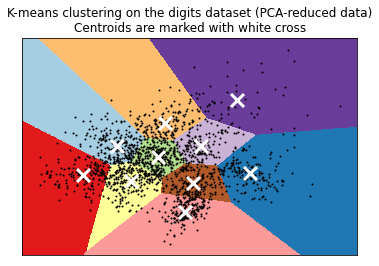

In [70]:
# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()